In [1]:
import pandas as pd
import pandas_datareader as pdr
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


sns.set_style("darkgrid")
sns.set_context("talk")

params = {
    "figure.figsize": (15, 5),
}
plt.rcParams.update(params)


In [2]:
def get_raw_data(index_name, retry_attempts=3):
    if index_name:
        while retry_attempts > 0:
            try:
                df = pdr.get_data_yahoo(index_name)
                retry_attempts = 0
                return df
            except:
                print(
                    "Data pull failed. {} retry attempts remaining".format(
                        retry_attempts
                    )
                )
                retry_attempts = retry_attempts - 1
    else:
        print("Invalid usage. Parameter index_name is required")
    return None


## Гипотеза


In [3]:
hist_data = pd.read_csv("../data/GSPC_2000_2019.csv")
hist_data["Date"] = pd.to_datetime(hist_data["Date"])

In [16]:
def split_data(
    stock: pd.Series, lookback: int, test_size: float
): #-> Tuple[np.array, np.array, np.array, np.array]:
    data_raw = stock.values
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback + 1):
        data.append(data_raw[index : index + lookback])

    data = np.array(data)
    test_set_size = int(np.round(test_size * data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]

    return x_train, y_train, x_test, y_test

In [17]:
X_train, X_val, y_train, y_val = split_data(hist_data[["Close"]], 30, 0.2)
X_val.shape

(4002, 1)

In [15]:
X_train.shape

(4002, 29, 1)

In [9]:
split_data(hist_data[["Close"]], 30, 0.2)

(array([[[1455.219971],
         [1399.420044],
         [1402.109985],
         ...,
         [1411.709961],
         [1416.829956],
         [1387.119995]],
 
        [[1399.420044],
         [1402.109985],
         [1403.449951],
         ...,
         [1416.829956],
         [1387.119995],
         [1389.939941]],
 
        [[1402.109985],
         [1403.449951],
         [1441.469971],
         ...,
         [1387.119995],
         [1389.939941],
         [1402.050049]],
 
        ...,
 
        [[2089.139893],
         [2088.870117],
         [2090.110107],
         ...,
         [2012.660034],
         [2016.709961],
         [1990.26001 ]],
 
        [[2088.870117],
         [2090.110107],
         [2080.409912],
         ...,
         [2016.709961],
         [1990.26001 ],
         [1943.089966]],
 
        [[2090.110107],
         [2080.409912],
         [2102.629883],
         ...,
         [1990.26001 ],
         [1943.089966],
         [1922.030029]]]),
 array([[1389.93994

In [4]:
from typing import Tuple

TRESHHOLD = 10
VAL = 10
LOOKBACK = 30

def get_signals(
    price: np.array, pred_price: np.array = None, treshhold: float = 10
) -> np.array:
    price = pd.Series(price)
    pred_price = pred_price if pred_price is not None else price
    day_change = price - pred_price.shift(-1)
    # Смотрим в будущее, если цена завтра > сегодня + treshhold, то сегодня покупаем
    signals = (day_change < -treshhold).astype(int)
    return signals


def calculate_profit(
    data: pd.DataFrame,
    val: float = 10,
    treshhold: float = 10,
    start_date=None,
    end_date=None,
    use_pred=False
) -> Tuple[int, int, int]:
    temp_df = data.set_index("Date")[start_date:end_date]
    pred_price = temp_df["pred"] if "pred" in temp_df.columns else None
    price = temp_df["pred"] if use_pred else temp_df["Close"] 
    signal = get_signals(price, pred_price, treshhold)
    temp_df["signal"] = signal
    # Объединяем так, чтобы в конечном датасете был отражён каждый день календаря
    # Пропуски в "signal" заполняем -1 (на выходных копим)
    df = pd.DataFrame(
        pd.date_range(temp_df.index[0], temp_df.index[-1]), columns=["Date"]
    )
    df = df.set_index("Date").join(temp_df)
    df["Close"] = df["Close"].fillna(method="ffill").fillna(method="backfill")
    df["signal"] = df["signal"].fillna(-1)
    price = df["Close"].values
    signal = df["signal"].values
    total_balance_simple = 0
    total_balance_invest = 0
    total_balance_smart = 0
    cur_val_invest = 0
    cur_val_smart = 0
    for i in range(len(signal)):
        total_balance_simple += val
        cur_val_invest += val
        cur_val_smart += val
        if signal[i] >= 0:
            if signal[i] > 0:
                total_balance_invest += cur_val_invest / price[i]
                total_balance_smart += cur_val_smart / price[i]
                cur_val_invest = 0
                cur_val_smart = 0
            else:
                total_balance_invest += cur_val_invest / price[i]
                cur_val_invest = 0
        if i == len(signal) - 1:
            total_balance_invest += cur_val_invest
            total_balance_smart += cur_val_smart
            total_balance_invest *= price[i]
            total_balance_smart *= price[i]
    return total_balance_simple, total_balance_invest, total_balance_smart

In [5]:
treshholds = list(range(50))
total_balances = [calculate_profit(hist_data, treshhold=treshhold) for treshhold in treshholds]

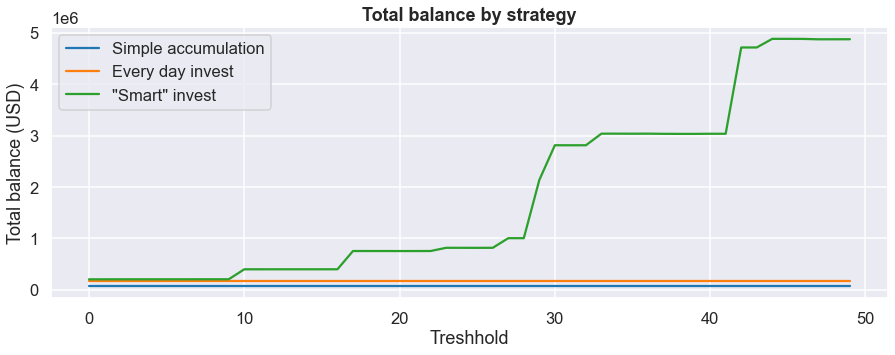

In [6]:
plt.plot(
    np.array(total_balances),
)
plt.title("Total balance by strategy", fontsize=18, fontweight="bold")
plt.legend(["Simple accumulation", "Every day invest", "\"Smart\" invest"])
plt.xlabel("Treshhold", fontsize=18)
plt.ylabel("Total balance (USD)", fontsize=18)
plt.show()


In [7]:
STOCK_INDEX = "^GSPC"

sp_df = get_raw_data(STOCK_INDEX)

print("Data Retrieved")

# reset index to get date_time as a column
sp_df = sp_df.reset_index()

# prepare the required dataframe
sp_df.rename(columns={"index": "Date"}, inplace=True)
sp_df = sp_df[["Date", "Close"]]

Data Retrieved


In [8]:
data = hist_data.append(sp_df.loc[sp_df["Date"] > hist_data["Date"].values[-1]])
data.head()

,Date,Close
0,2000-01-03,1455.219971
1,2000-01-04,1399.420044
2,2000-01-05,1402.109985
3,2000-01-06,1403.449951
4,2000-01-07,1441.469971


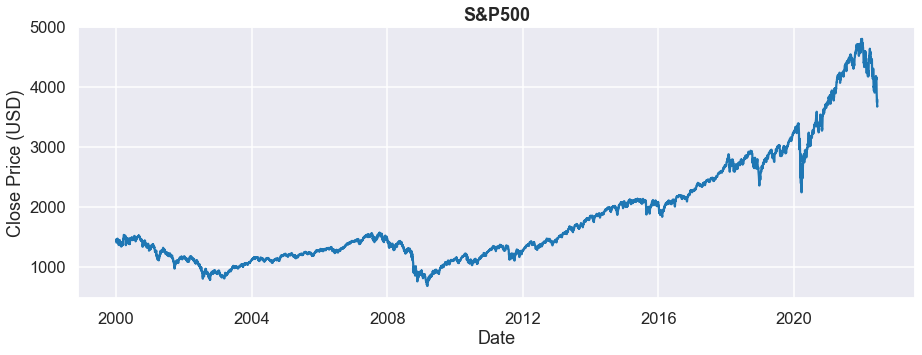

In [9]:
plt.plot(data["Date"], data["Close"])
plt.title("S&P500", fontsize=18, fontweight="bold")
plt.xlabel("Date", fontsize=18)
plt.ylabel("Close Price (USD)", fontsize=18)
plt.show()

## Normalize data

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
data["Close_norm"] = scaler.fit_transform(data["Close"].values.reshape(-1, 1))

In [11]:
def split_data(stock, lookback):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback + 1): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]


    return [x_train, y_train, x_test, y_test]

In [12]:
lookback = 30 # choose sequence length
x_train, y_train, x_test, y_test = split_data(data[["Close_norm"]], lookback)
print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)

x_train.shape =  (4498, 29, 1)
y_train.shape =  (4498, 1)
x_test.shape =  (1125, 29, 1)
y_test.shape =  (1125, 1)


In [13]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [14]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 50

In [15]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [16]:
hist = np.zeros(num_epochs)
gru = []
for epoch in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_gru)
    if epoch % 10 == 0:
        print("Epoch ", epoch, "MSE: ", loss.item())
    hist[epoch] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

Epoch  0 MSE:  0.3540065288543701
Epoch  10 MSE:  0.037484534084796906
Epoch  20 MSE:  0.01785413734614849
Epoch  30 MSE:  0.002877874532714486
Epoch  40 MSE:  0.00015542478649877012


In [17]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_gru.detach().numpy()))

Text(0.5, 1.0, 'Training Loss')

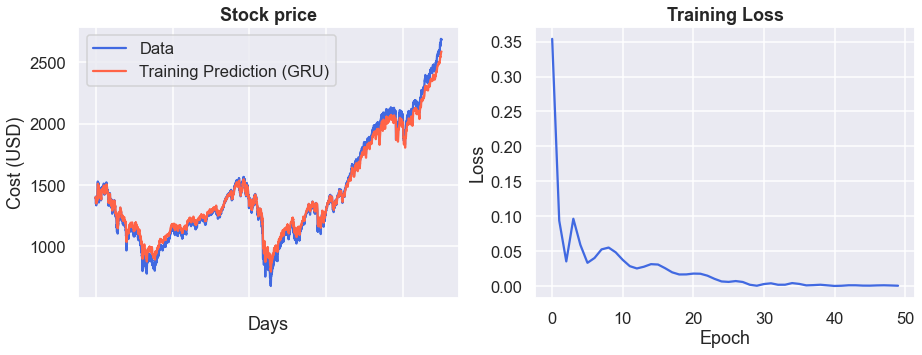

In [18]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(
    x=original.index, y=original[0], label="Data", color="royalblue"
)
ax = sns.lineplot(
    x=predict.index,
    y=predict[0],
    label="Training Prediction (GRU)",
    color="tomato",
)
ax.set_title("Stock price", fontweight="bold")
ax.set_xlabel("Days")
ax.set_ylabel("Cost (USD)")
ax.set_xticklabels("", size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color="royalblue")
ax.set_xlabel("Epoch", )
ax.set_ylabel("Loss", )
ax.set_title("Training Loss", fontweight="bold")


In [19]:
import math
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_gru.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_gru.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
gru.append(trainScore)
gru.append(testScore)

Train Score: 45.14 RMSE
Test Score: 256.28 RMSE


In [20]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(data[["Close"]])
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(data[["Close"]])
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(data["Close"]), :] = y_test_pred

original = scaler.inverse_transform(data["Close_norm"].values.reshape(-1,1))

predictions = np.append(original, trainPredictPlot, axis=1)
predictions = np.append(predictions, testPredictPlot,  axis=1)
result = pd.DataFrame(predictions)

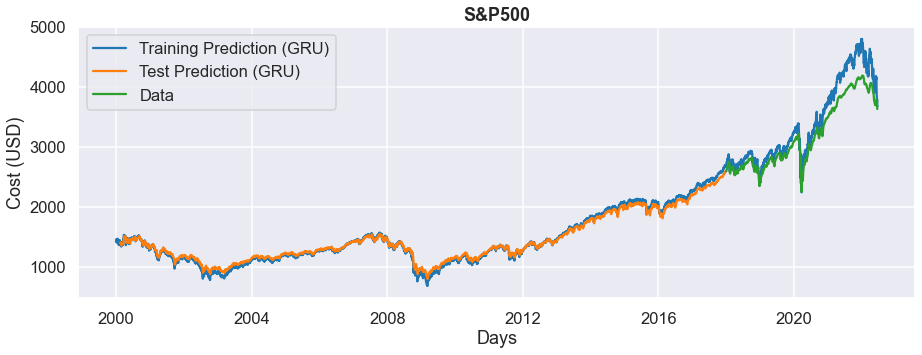

In [21]:
plt.plot(
    data["Date"],
    np.array(result),
)
plt.title("S&P500", fontsize=18, fontweight="bold")
plt.legend(["Training Prediction (GRU)", "Test Prediction (GRU)", "Data"])
plt.xlabel("Days", fontsize=18)
plt.ylabel("Cost (USD)", fontsize=18)
plt.show()

In [22]:
result["Date"] = data["Date"].values
result["pred"] = result[1].fillna(result[2])
result["Close"] = result[0]
result.head(31)

,0,1,2,Date,pred,Close
0,1455.219971,NaN,NaN,2000-01-03,NaN,1455.219971
1,1399.420044,NaN,NaN,2000-01-04,NaN,1399.420044
2,1402.109985,NaN,NaN,2000-01-05,NaN,1402.109985
3,1403.449951,NaN,NaN,2000-01-06,NaN,1403.449951
4,1441.469971,NaN,NaN,2000-01-07,NaN,1441.469971
5,1457.599976,NaN,NaN,2000-01-10,NaN,1457.599976
6,1438.560059,NaN,NaN,2000-01-11,NaN,1438.560059
7,1432.250000,NaN,NaN,2000-01-12,NaN,1432.250000
8,1449.680054,NaN,NaN,2000-01-13,NaN,1449.680054
9,1465.150024,NaN,NaN,2000-01-14,NaN,1465.150024


In [23]:
# Значения на оригинальных данных (если бы знали будушее):
calculate_profit(result[["Date", "Close"]], start_date="2000-02-15")

(81590, 199445.34827042394, 312349.9045756522)

In [24]:
# Значения на основе предсказаний на след день - исторические данные:
calculate_profit(result, start_date="2000-02-15")

(81590, 199445.34827042394, 27238058.187695164)

In [25]:
# Значения на основе предсказаний на след день - предсказание на предыдущие:
calculate_profit(result, start_date="2000-02-15", use_pred=True)

(81590, 199445.34827042394, 711516.513004142)

In [26]:
start_date="2015-01-01"
# Значения на основе предсказаний на след день - исторические данные:
calculate_profit(result, start_date=start_date)

(27240, 36750.91542493148, 27075690.38412464)

In [27]:
# Значения на основе предсказаний на след день - предсказание на предыдущие:
calculate_profit(result, start_date=start_date, use_pred=True)

(27240, 36750.91542493148, 550761.9194450346)

In [28]:
np.sum(get_signals(result["Close"]) == get_signals(result["Close"], result["pred"]))

3028

In [29]:
np.sum(get_signals(result["Close"]) == get_signals(result["pred"]))

4098

In [30]:
result["pred"]

0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
           ...     
5647    3767.272705
5648    3736.215332
5649    3698.125732
5650    3664.927490
5651    3626.214111
Name: pred, Length: 5652, dtype: float64

In [37]:
def get_tomorow_close_prediction(
    data: pd.DataFrame, model: GRU, scaler: MinMaxScaler, lookback: int = 30
) -> float:
    last_data = data["Close"][-lookback + 1 :].values.reshape(-1, 1)
    norm_last_data = scaler.transform(last_data)
    norm_last_data = torch.from_numpy(
        np.expand_dims(norm_last_data, axis=0)
    ).type(torch.Tensor)
    pred_norm = model(norm_last_data).detach().numpy()
    pred = scaler.inverse_transform(pred_norm)
    return pred[0][0]

def get_today_signal(data: pd.DataFrame, pred_price: np.array, use_pred: bool = False) -> int:
    return get_signals(np.append(data["pred" if use_pred else "Close"].values[-1], pred_price)).values[0]

def get_today_signal_simple(today_price: float, pred_price: float) -> int:
    return get_signals(np.array([today_price, pred_price])).values[0]

In [32]:
pred_price = get_tomorow_close_prediction(result, model, scaler, lookback=30)
pred_price

3589.6611

In [33]:
pred_price = get_tomorow_close_prediction(result, model, scaler, lookback=30)
get_today_signal(result, pred_price, use_pred=True)

0